# Projeto 2: Aprendizagem Supervisionada - Previsão de aceitação de empréstimo

## Instalação de bibliotecas

Neste projeto usámos as seguintes bibliotecas:

- [pandas](https://pandas.pydata.org/) - 
- [numpy](https://numpy.org/) - 
- [sk-learn](https://scikit-learn.org) -  
- [imbalanced-learn](https://imbalanced-learn.org) - 
- [xg-boost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) - 
- [matplotlib](https://matplotlib.org/) -
- [seaborn](https://seaborn.pydata.org/) -

Estas bibliotecas e as suas dependências podem ser instaladas ao correr o seguinte comando no root do projeto:

```bash
pip install -r requirements.txt
``` 

In [37]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## Pré-processamento de dados

### Parser:

In [ ]:

def feature_engineering(df):
    median_emp_length = df['person_emp_length'].replace(0, np.nan).median()
    df['person_emp_length'] = df['person_emp_length'].replace(0, median_emp_length)

    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate'] / 100  

    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'] + 1e-5)
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'] + 1e-5)

    df['loan_to_credit_hist'] = df['loan_amnt'] / (df['cb_person_cred_hist_length'] + 1e-5)
    df['loan_to_income_ratio'] = df['loan_amnt'] / (df['person_income'] + 1e-5)

    return df



def preprocess_train(file_path: str, balance_classes: bool = False, use_feature_eng: bool = False):
    df = pd.read_csv(file_path)
    df = df.drop(columns=['id'])

    if use_feature_eng:
        df = feature_engineering(df)

    df = pd.get_dummies(df, columns=[
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
        'cb_person_default_on_file'
    ], drop_first=True)

    df = df.dropna()

    X = df.drop(columns=['loan_status'])
    y = df['loan_status']

    # Divide treino/validação antes de qualquer escala ou balanceamento
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    class_weights_dict = None  # Default

    if balance_classes:
       
       
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weights_dict = dict(zip(np.unique(y_train), class_weights))

    # Agora escala os dados (separadamente treino e validação!)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    if balance_classes:
        return X_train_scaled, X_val_scaled, y_train, y_val, scaler, X.columns, class_weights_dict
    else:
        return X_train_scaled, X_val_scaled, y_train, y_val, scaler, X.columns


def preprocess_test(file_path: str, scaler, columns, use_feature_eng: bool = False):
    df = pd.read_csv(file_path)
    ids = df['id']
    df = df.drop(columns=['id'])

    if use_feature_eng:
        df = feature_engineering(df)

    df = pd.get_dummies(df, columns=[
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
        'cb_person_default_on_file'
    ], drop_first=True)

    for col in columns:
        if col not in df.columns:
            df[col] = 0
    df = df[columns]  # Reordenar colunas

    X_scaled = scaler.transform(df)

    return X_scaled, ids

#### preprocess_train

- Inicialmente **removemos** variáveis não importantes como **Id**.

    ```python
    df = df.drop(columns=['id'])
    ```

- **Transformação** de variáveis **categóricas** em variáveis **binárias** (dummies).

    ```python
    df = pd.get_dummies(df, columns=[
        'person_home_ownership',
        'loan_intent',
        'loan_grade',
        'cb_person_default_on_file'
    ], drop_first=True)
    ```
- Como temos **drop_first=True** ou seja vamos ter **mais N(numero de atributos) - 1** de **colunas**. 

- Variaveis categoricas:
    - person_home_ownership:
        - Own
        - Mortgage
        - Rent
    - loan_intent:
        - Education
        - Medical
        - Personal
        - Venture
        - Debt Consolidation
        - Home Improvement
    - loan_grade:
        - A
        - B
        - C
    - cb_person_default_on_file:
        - Y
        - N

Dentro do treino dividimos entre treino e teste, 80% para treino real (X_train, y_train) e 20% para validação (X_val, y_val). Desta forma podemos testar o modelo antes de usar no teste oficial.

```python
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
```

## Métodos para equilibrar resultados:

### balance_classes:

- Este método ajusta automaticamente o peso de cada classe com base na sua frequência inversa no conjunto de treino.
- Ou seja, dá mais peso às classes minoritárias e menos peso às maioritárias, sem alterar os dados em si.

```python
if balance_classes:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(zip(np.unique(y_train), class_weights))
```

### Feature engineering:
- Criar novas variáveis que combinam informação relevante para ajudar o modelo a detetar padrões mais facilmente — especialmente padrões relacionados com capacidade financeira e risco.

```python
def feature_engineering(df):
    median_emp_length = df['person_emp_length'].replace(0, np.nan).median()
    df['person_emp_length'] = df['person_emp_length'].replace(0, median_emp_length)

    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate'] / 100  

    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'] + 1e-5)
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'] + 1e-5)

    df['loan_to_credit_hist'] = df['loan_amnt'] / (df['cb_person_cred_hist_length'] + 1e-5)
    df['loan_to_income_ratio'] = df['loan_amnt'] / (df['person_income'] + 1e-5)

    return df
```

#### Variaveis usadas:

- **Correção** de valores **0** na coluna **person_emp_length** (anos de experiência profissional):
    - Os zeros são substituídos pela mediana da coluna para evitar valores inválidos que podem prejudicar os cálculos subsequentes, nomeadamente divisões por zero. Isto melhora a qualidade e a robustez dos novos atributos criado

    ```python
    median_emp_length = df['person_emp_length'].replace(0, np.nan).median()
    df['person_emp_length'] = df['person_emp_length'].replace(0, median_emp_length)
    ```

- **financial_burden**:
    - Calcula uma estimativa do custo total dos juros do empréstimo, dado pelo produto do montante do empréstimo (loan_amnt) pela taxa de juro (loan_int_rate). Esta variável ajuda a captar o peso financeiro do empréstimo para o   indivíduo, que pode estar correlacionado com a probabilidade de incumprimento.

    ```python
    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate'] / 100
    ```

- **income_per_year_emp**:
    - Mede o rendimento médio anual do indivíduo, obtido ao dividir o rendimento anual (person_income) pelo tempo de experiência profissional (person_emp_length). Esta variável reflete a capacidade financeira ajustada pelo tempo no mercado de trabalho, podendo indicar estabilidade ou crescimento da carreira.

    ```python
    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'] + 1e-5)
    ```

- **int_per_year_emp**:
    - Calcula a taxa de juro anual ajustada pelo tempo de experiência, dividindo a taxa de juro do empréstimo pela experiência profissional. Esta métrica pode evidenciar se o custo do empréstimo é elevado relativamente à experiência financeira da pessoa, o que pode impactar no risco de incumprimento.
    ```python
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'] + 1e-5)
    ```
- **loan_to_credit_hist**:
    - Mede a relação entre o montante do empréstimo e o tempo de histórico de crédito, calculada dividindo o montante do empréstimo (loan_amnt) pelo tempo de histórico de crédito (cb_person_cred_hist_length). Esta variável coloco o montante do empréstimo em relação à experiência de crédito da pessoa, ajudando a identificar potenciais riscos.

    ```python
    df['loan_to_credit_hist'] = df['loan_amnt'] / (df['cb_person_cred_hist_length'] + 1e-5)
    ```

- **loan_to_income_ratio**:
    - Calcula a relação entre o montante do empréstimo e quanto dinheiro a pessoa ganha anualmente, dividindo o montante do empréstimo (loan_amnt) pela receita anual (person_income). Esta métrica ajuda a avaliar a capacidade de pagamento do indivíduo, conseguimos então avaliar melhor se o empréstimo é excessivo em relação à capacidade de pagamento do indivíduo.

    ```python
    df['loan_to_income_ratio'] = df['loan_amnt'] / (df['person_income'] + 1e-5)
    ```
## Machine learning models

O treino dos modelos é realizado através da função train_model(), com os parâmetros:
  - trainFile_path: str - path para o ficheiro csv de treino
  - classWeightbool: bool - true -> ativado, false -> desativado, o ajuste automático do peso das classes (dá mais peso às classes minoritárias e menos peso às maioritárias, sem alterar os dados em si)
  - use_feature_eng: bool - true-> ativada, false ->desativada, a feature engineering (usa as novas variáveis criadas para ajudar o modelo a detetar padrões mais facilmente)


In [ ]:
def train_model(trainFile_path: str, model, classWeightbool: bool = False, use_feature_eng: bool = False):
    if classWeightbool:
        # preprocess_train retorna class_weights quando balance_classes=True
        X_train, X_val, y_train, y_val, scaler, columns, class_weights = preprocess_train(
            trainFile_path, balance_classes=True, use_feature_eng=use_feature_eng
        )
        # Ajusta parâmetros do modelo para classes desbalanceadas
        if isinstance(model, XGBClassifier):
            counter = Counter(y_train)
            weight = counter[0] / counter[1]
            model.set_params(scale_pos_weight=weight)
        elif hasattr(model, 'class_weight') and model.class_weight is None:
            model.class_weight = class_weights
    else:
        # preprocess_train não retorna class_weights quando balance_classes=False
        X_train, X_val, y_train, y_val, scaler, columns = preprocess_train(
            trainFile_path, balance_classes=False, use_feature_eng=use_feature_eng
        )
        class_weights = None  # para consistência
    
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    y_pred = model.predict(X_val)
    end_pred = time.time()

    print("Exatidão (validação):", accuracy_score(y_val, y_pred))
    print("\nClassification report:\n", classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred)
    print("Matriz de confusão:")
    print(cm)

    print(f"Tempo de treino: {end_train - start_train:.4f} segundos")
    print(f"Tempo de predição (validação): {end_pred - start_pred:.4f} segundos")

    return model, scaler, columns

O teste dos modelos é realizado através da função test_model() com os parâmetros:
- testFile_path: str - path para o ficheiro csv de teste
- model: str - modelo a usar (logistic_regression, random_forest, xgboost)
- scaler: StandardScaler - tipo de scaler a usar
- columns: list[str] - lista de colunas a usar
- use_feature_eng: bool - true-> ativada, false ->desativada, a feature engineering (usa as novas variáveis criadas para ajudar o modelo a detetar padrões mais facilmente)

In [ ]:
def test_model(testFile_path: str, model, scaler, columns, use_feature_eng: bool = False):
    start_test = time.time()
    X_test, ids = preprocess_test(testFile_path, scaler, columns, use_feature_eng=use_feature_eng)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        result = y_proba
    else:
        y_pred = model.predict(X_test)
        result = y_pred
    end_test = time.time()

    result_df = pd.DataFrame({
        'id': ids,
        'loan_status': result
    })

    result_df.to_csv("submission.csv", index=False)
    print("Submission saved on 'submission.csv'")
    print(f"Tempo para processar teste: {end_test - start_test:.4f} segundos")



> **Nota:** Nas seguintes secções o calculo do tempo (tempo = tempo_treino + tempo_teste)

### Logistic Regression:

##### Parâmetros do modelo:

- LogisticRegression(max_iter=1000, random_state=42, classWeightbool, use_feature_eng)
  - max_iter = 1000
  - random_state = 42
  - classWeightbool
  - use_feature_eng

##### Parâmetros da função wrapper:

Com a função logisticRegression() que tem os parâmetros:
- trainFile_path: str - path para o ficheiro csv de treino
- testFile_path: str - path para o ficheiro csv de teste
- classWeightbool: bool - true -> ativado, false -> desativado, o ajuste automático do peso das classes (dá mais peso às classes minoritárias e menos peso às maioritárias, sem alterar os dados em si)
- use_feature_eng: bool - true-> ativada, false ->desativada, a feature engineering (usa as novas variáveis criadas para ajudar o modelo a detetar padrões mais facilmente)

In [11]:
def logisticRegression(trainFile_path: str, testFile_path: str, classWeightbool: bool, use_feature_eng: bool):
    start_time = time.time()

    modelUsed = LogisticRegression(max_iter=1000, random_state=42)
    model, scaler, columns = train_model(trainFile_path, modelUsed, classWeightbool, use_feature_eng)
    test_model(testFile_path, model, scaler, columns,use_feature_eng)

    end_time = time.time()
    print(f"[LogisticRegression] Tempo de execução: {end_time - start_time:.2f} segundos")

#### Treino:

In [19]:
logisticRegression('data/train.csv', 'data/test.csv', classWeightbool=False, use_feature_eng=False)

Exatidão (validação): 0.911842441810896

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     10087
           1       0.77      0.53      0.63      1642

    accuracy                           0.91     11729
   macro avg       0.85      0.75      0.79     11729
weighted avg       0.90      0.91      0.90     11729

Matriz de confusão:
[[9832  255]
 [ 779  863]]
Tempo de treino: 1.5373 segundos
Tempo de predição (validação): 0.0010 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.1152 segundos
[LogisticRegression] Tempo de execução: 2.10 segundos


##### Resultados:

**Exatidão (validação):** 0.911842441810896

**Classification report:**

| Classification | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.93      | 0.97   | 0.95     | 10087   |
| 1     | 0.77      | 0.53   | 0.63     | 1642    |
| **Accuracy**     |        |          | 0.91     | 11729   |
| **Macro Avg**    | 0.85   | 0.75     | 0.79     | 11729   |
| **Weighted Avg** | 0.90   | 0.91     | 0.90     | 11729   |

**Matriz de confusão:**
[[9832  255]
 [ 779  863]]

**Tempo de treino:** 0.0700 segundos

**Tempo de predição (validação):** 0.0000 segundos

**Tempo para processar teste:** 0.0810 segundos

**Tempo de execução:** 0.37 segundos

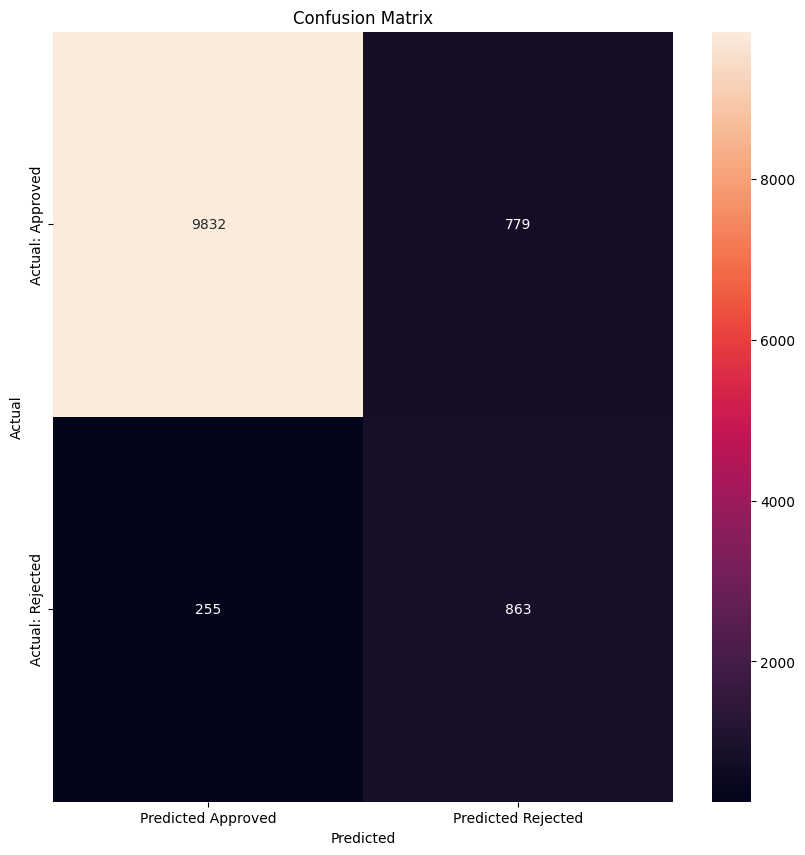

In [43]:
def confusion_matrix_plot(approved_true, approved_pred, rejected_true, rejected_pred):
    data = {
        'Predicted Approved': [approved_true, approved_pred],
        'Predicted Rejected': [rejected_true, rejected_pred]
    }
    df_cm = pd.DataFrame(data, index=['Actual: Approved', 'Actual: Rejected'])
    plt.figure(figsize=(10, 10))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

confusion_matrix_plot(9832, 255, 779, 863)

##### Conclusão:

- Bons resultados para um modelo tão simples porem existe um possivel fator problematico que é a taxa de recall para load approval 1 que é de 0,53 significa que o modelo só identifica 53% dos clientes problemáticos.
- O que pode ser causado pelo um maior numero de 0 do que 1
- Solução: 
    - usar tecnicas para equilibrar os dados

#### Treino com balance_classes:

In [21]:
logisticRegression('data/train.csv', 'data/test.csv', classWeightbool=True, use_feature_eng=False)

Exatidão (validação): 0.8397987893256033

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90     10087
           1       0.46      0.83      0.59      1642

    accuracy                           0.84     11729
   macro avg       0.71      0.84      0.75     11729
weighted avg       0.90      0.84      0.86     11729

Matriz de confusão:
[[8484 1603]
 [ 276 1366]]
Tempo de treino: 1.3729 segundos
Tempo de predição (validação): 0.0011 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.1005 segundos
[LogisticRegression] Tempo de execução: 1.93 segundos


##### Resultados:

**Exatidão (validação):** 0.8397987893256033

**Classification report:**

| Classification | Precision | Recall | F1-Score | Support |
|----------------|-----------|--------|----------|---------|
| 0              | 0.97      | 0.84   | 0.90     | 10087   |
| 1              | 0.46      | 0.83   | 0.59     | 1642    |
| **Accuracy**   |           |        | 0.84     | 11729   |
| **Macro Avg**  | 0.71      | 0.84   | 0.75     | 11729   |
| **Weighted Avg** | 0.90    | 0.84   | 0.86     | 11729   |


**Matriz de confusão:**
[[8484 1603]
 [ 276 1366]]

**Tempo de treino:** 0.0780 segundos

**Tempo de predição (validação):** 0.0000 segundos

**Tempo para processar teste:** 0.0900 segundos

**Tempo de execução:** 0.39 segundos

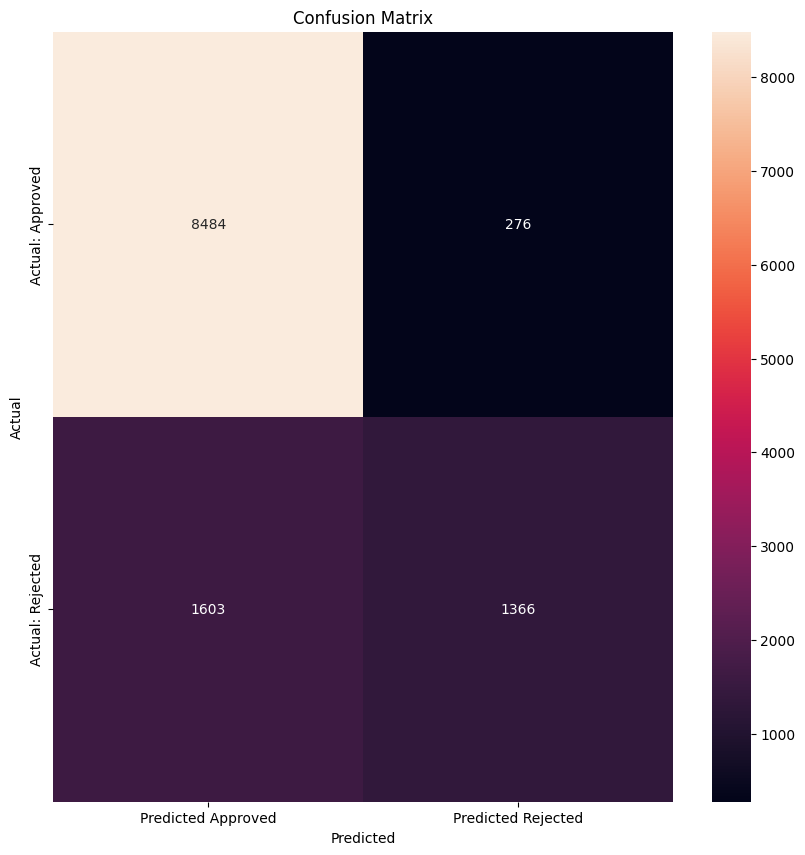

In [44]:
confusion_matrix_plot(8484, 1603, 276, 1366)

##### Conclusão:

- Melhorou o recall porem pirou outras metricas talvez mais importantes como a precisao e o f1-score, levando um aumento do numero de falsos negativos
- Isto aconteceu pois o modelo dá mais importância à classe minoritária (no teu caso, o loan_status = 1). 

#### Uso de Feature engineering

In [22]:
logisticRegression('data/train.csv', 'data/test.csv', classWeightbool=False, use_feature_eng=True)

Exatidão (validação): 0.9149970159433882

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     10087
           1       0.78      0.55      0.64      1642

    accuracy                           0.91     11729
   macro avg       0.85      0.76      0.80     11729
weighted avg       0.91      0.91      0.91     11729

Matriz de confusão:
[[9828  259]
 [ 738  904]]
Tempo de treino: 2.9902 segundos
Tempo de predição (validação): 0.0008 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.1352 segundos
[LogisticRegression] Tempo de execução: 3.64 segundos


**Exatidão (validação):** 0.9149970159433882

**Classification report:**

| Classification | Precision | Recall | F1-Score | Support |
|----------------|-----------|--------|----------|---------|
| 0              | 0.93      | 0.97   | 0.95     | 10087   |
| 1              | 0.78      | 0.55   | 0.64     | 1642    |
| **Accuracy**   |           |        | 0.91     | 11729   |
| **Macro Avg**  | 0.85      | 0.76   | 0.80     | 11729   |
| **Weighted Avg** | 0.91    | 0.91   | 0.91     | 11729   |

**Matriz de confusão:**
[[9828  259]
 [ 738  904]]

**Tempo de treino:** 0.1280 segundos

**Tempo de predição (validação):** 0.0010 segundos

**Tempo para processar teste:** 0.0950 segundos

**Tempo de execução:** 0.48 segundos

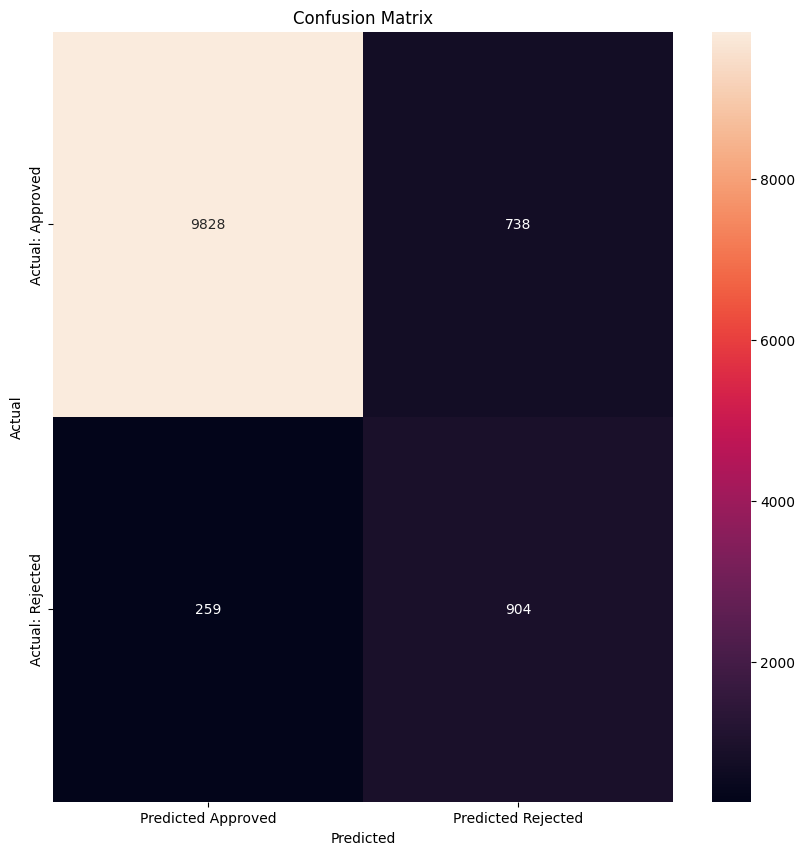

In [45]:
confusion_matrix_plot(9828, 259, 738, 904)

##### Análise dos resultados:

- O recall subiu de 0.53 → 0.55

- O f1-score subiu de 0.63 → 0.64

- Isto significa que o modelo passou a identificar um pouco melhor quem não paga o empréstimo, sem perder qualidade nos outros caso

##### Interpretação

- Class weights também estão a ajudar o modelo a tratar a classe 1 com mais importância.

- O teste (sem nada) obtém maior exatidão  mas ignora a classe 1, o que é problematico em problemas de fraude ou risco.

### Random Forest Classifier:

##### Parâmetros do modelo:
- randomForestClassifier(n_estimators=100, random_state=42, classWeightbool, use_feature_eng)
  - n_estimators = 100
  - random_state = 42
  - classWeightbool
  - use_feature_eng

##### Parâmetros da função wrapper:
Com a função randomForest() que tem os parâmetros:
- trainFile_path: str - path para o ficheiro csv de treino
- testFile_path: str - path para o ficheiro csv de teste
- classWeightbool: bool - true -> ativado, false -> desativado, o ajuste automático do peso das classes (dá mais peso às classes minoritárias e menos peso às maioritárias, sem alterar os dados em si)
- use_feature_eng: bool - true-> ativada, false ->desativada, a feature engineering (usa as novas variáveis criadas para ajudar o modelo a detetar padrões mais facilmente)

#### Treino:

In [12]:
def randomForest(trainFile_path: str, testFile_path: str, classWeightbool: bool,use_feature_eng: bool):
        start_time = time.time()

        modelUsed = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced' if classWeightbool else None
        )
        model, scaler, columns = train_model(trainFile_path, modelUsed, classWeightbool,use_feature_eng)
        test_model(testFile_path, model, scaler, columns,use_feature_eng)

        end_time = time.time()
        print(f"[RandomForest] Tempo de execução: {end_time - start_time:.2f} segundos")

In [23]:
randomForest('data/train.csv', 'data/test.csv', classWeightbool=False, use_feature_eng=False)

Exatidão (validação): 0.9517435416489044

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.92      0.72      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729

Matriz de confusão:
[[9977  110]
 [ 456 1186]]
Tempo de treino: 5.6249 segundos
Tempo de predição (validação): 0.2146 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.7609 segundos
[RandomForest] Tempo de execução: 6.94 segundos


##### Resultados:

**Exatidão (validação):** 0.9517435416489044

**Classification report:**

| Classification   | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0                | 0.96      | 0.99   | 0.97     | 10087   |
| 1                | 0.92      | 0.72   | 0.81     | 1642    |
| **Accuracy**     |           |        | 0.95     | 11729   |
| **Macro Avg**    | 0.94      | 0.86   | 0.89     | 11729   |
| **Weighted Avg** | 0.95      | 0.95   | 0.95     | 11729   |

**Matriz de confusão:**
[[9977  110]
 [ 456 1186]]

**Tempo de treino:** 4.2620 segundos

**Tempo de predição (validação):** 0.1930 segundos

**Tempo para processar teste:** 0.6830 segundos

**Tempo de execução:** 5.36 segundos

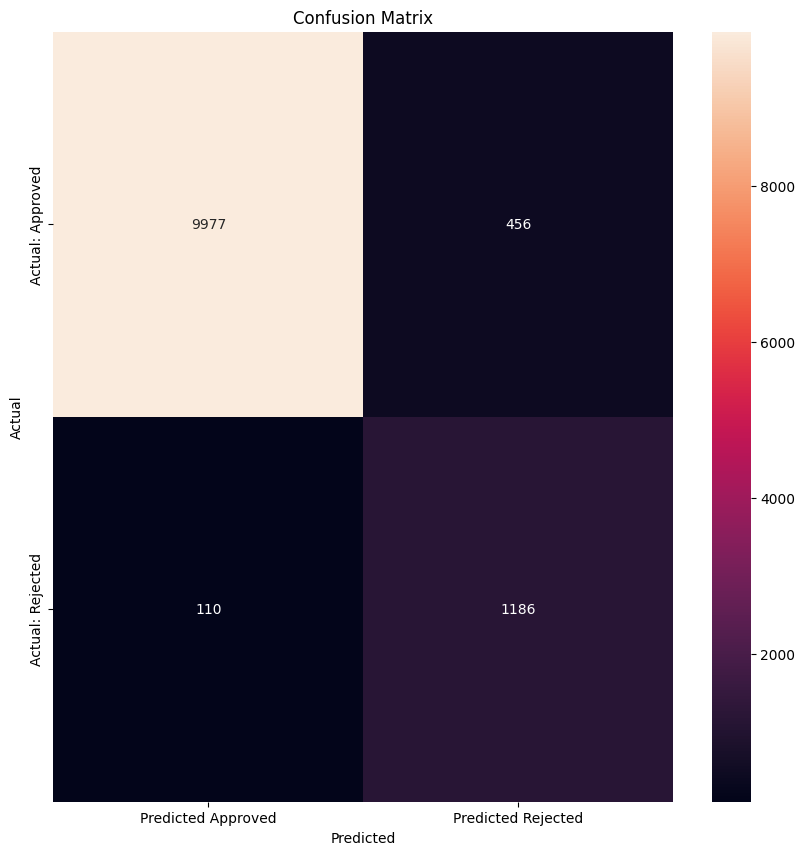

In [46]:
confusion_matrix_plot(9977, 110, 456, 1186)

##### Conclusão:

- Foi especialmente superior na classe minoritária, onde o modelo de regressão logística teve um desempenho mais fraco (recall 0.53 vs 0.72).

- Não foi necessário Equilibrio explícito ( class_weight) para a Random Forest ter um bom desempenho — isso é esperado, porque Random Forest lida melhor com desEquilibrio ao não ser um modelo linear e ao fazer bootstrapping com vários subconjuntos dos dados.

#### Random Forest Classifier com class_weight:

In [24]:
randomForest('data/train.csv', 'data/test.csv', classWeightbool=True, use_feature_eng=False)

Exatidão (validação): 0.9514877653678916

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10087
           1       0.92      0.71      0.80      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729

Matriz de confusão:
[[9989   98]
 [ 471 1171]]
Tempo de treino: 5.5456 segundos
Tempo de predição (validação): 0.2064 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.7668 segundos
[RandomForest] Tempo de execução: 6.78 segundos


##### Resultados:

**Exatidão (validação):** 0.9514877653678916

**Classification report:**

| Classification   | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0                | 0.95      | 0.99   | 0.97     | 10087   |
| 1                | 0.92      | 0.71   | 0.80     | 1642    |
| **Accuracy**     |           |        | 0.95     | 11729   |
| **Macro Avg**    | 0.94      | 0.85   | 0.89     | 11729   |
| **Weighted Avg** | 0.95      | 0.95   | 0.95     | 11729   |

**Matriz de confusão:**
[[9989   98]
 [ 471 1171]]

**Tempo de treino:** 4.3159 segundos

**Tempo de predição (validação):** 0.1670 segundos

**Tempo para processar teste:** 0.6889 segundos

**Tempo de execução:** 5.38 segundos

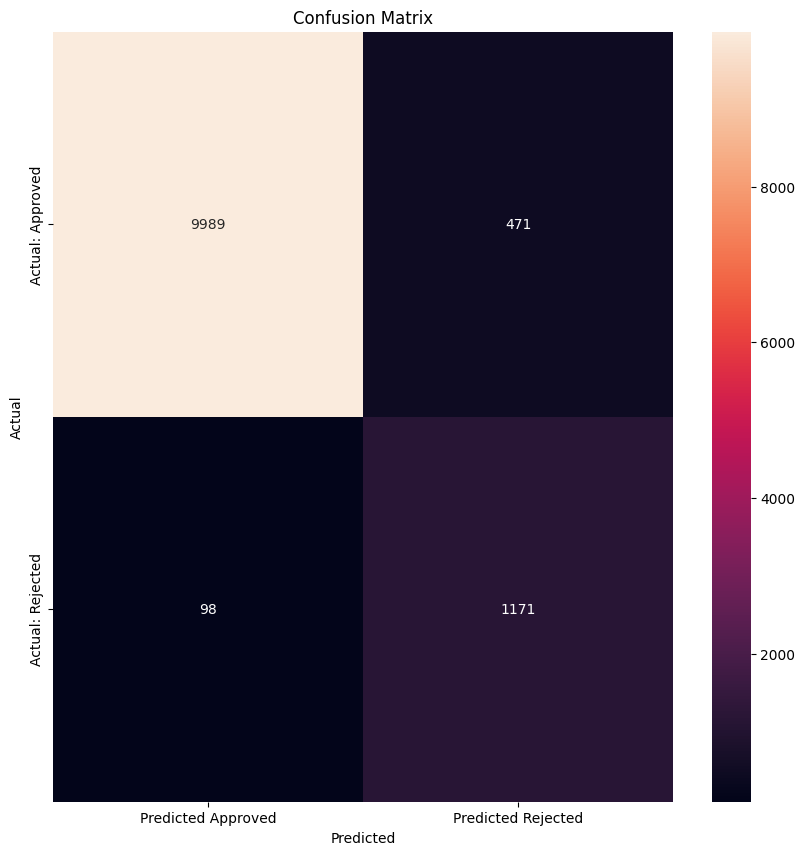

In [47]:
confusion_matrix_plot(9989, 98, 471, 1171)

##### Conclusão:

- Random Forest com class_weight não tem qualquer melhoria mas ja era esperado   porque Random Forest lida melhor com desEquilibrio ao não ser um modelo linear e ao fazer bootstrapping com vários subconjuntos dos dados.


#### Random Forest Classifier com Feature engineering:

In [25]:
randomForest('data/train.csv', 'data/test.csv', classWeightbool=False, use_feature_eng=True)

Exatidão (validação): 0.9470543098303351

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10087
           1       0.89      0.71      0.79      1642

    accuracy                           0.95     11729
   macro avg       0.92      0.85      0.88     11729
weighted avg       0.95      0.95      0.94     11729

Matriz de confusão:
[[9950  137]
 [ 484 1158]]
Tempo de treino: 11.3646 segundos
Tempo de predição (validação): 0.2149 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.9898 segundos
[RandomForest] Tempo de execução: 12.84 segundos


##### Resultados:

**Exatidão (validação):** 0.9470543098303351

**Classification report:**

| Classification   | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0                | 0.95      | 0.99   | 0.97     | 10087   |
| 1                | 0.89      | 0.71   | 0.79     | 1642    |
| **Accuracy**     |           |        | 0.95     | 11729   |
| **Macro Avg**    | 0.92      | 0.85   | 0.88     | 11729   |
| **Weighted Avg** | 0.95      | 0.95   | 0.94     | 11729   |

**Matriz de confusão:**
[[9950  137]
 [ 484 1158]]

**Tempo de treino:** 8.4121 segundos

**Tempo de predição (validação):** 0.1850 segundos

**Tempo para processar teste:** 0.7240 segundos

**Tempo de execução:** 9.57 segundos

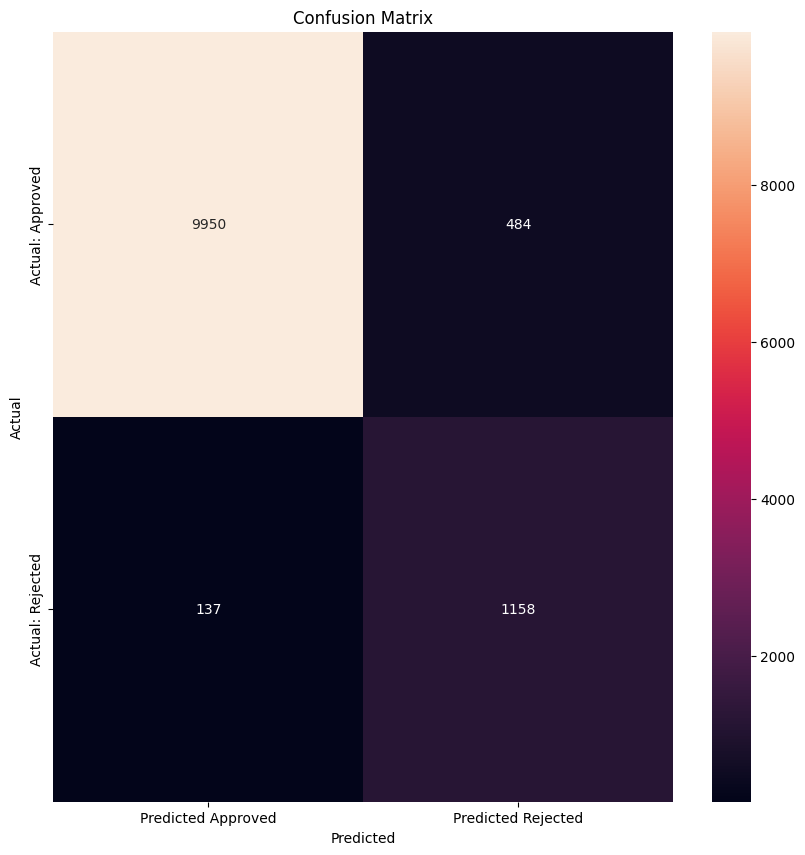

In [48]:
confusion_matrix_plot(9950, 137, 484, 1158)

##### Conclusão:

- Estas features podem a acrescentar alguma redundancia desbalancear a árvore ao fazer splits em features artificiais menos relevantes

### XGBoost:

##### Parâmetros do modelo:
- XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, subsmple=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss')
  - n_estimators = 100
  - random_state = 42
  - learning_rate = 0.1
  - max_depth = 6
  - subsmple = 0.8
  - colsample_bytree = 0.8
  - random_state = 42
  - eval_metric = 'logloss'

##### Parâmetros da função wrapper:
Com a função xboost_model() que tem os parâmetros:
- trainFile_path: str - path para o ficheiro csv de treino
- testFile_path: str - path para o ficheiro csv de teste
- classWeightbool: bool - true -> ativado, false -> desativado, o ajuste automático do peso das classes (dá mais peso às classes minoritárias e menos peso às maioritárias, sem alterar os dados em si)
- use_feature_eng: bool - true-> ativada, false ->desativada, a feature engineering (usa as novas variáveis criadas para ajudar o modelo a detetar padrões mais facilmente)

In [26]:
def xgboost_model(trainFile_path: str, testFile_path: str, classWeightbool: bool, use_feature_eng: bool):
    start_time = time.time()

    modelUsed = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
    )

    # Treina e testa o modelo
    model, scaler, columns = train_model(trainFile_path, modelUsed, classWeightbool, use_feature_eng)
    test_model(testFile_path, model, scaler, columns, use_feature_eng)

    end_time = time.time()
    print(f"[XGBoost] Tempo de execução: {end_time - start_time:.2f} segundos")


#### Treino:

In [27]:
xgboost_model('data/train.csv', 'data/test.csv', classWeightbool=False, use_feature_eng=False)

Exatidão (validação): 0.9533634580953193

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.91      0.74      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729

Matriz de confusão:
[[9974  113]
 [ 434 1208]]
Tempo de treino: 1.7767 segundos
Tempo de predição (validação): 0.0144 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.1084 segundos
[XGBoost] Tempo de execução: 2.17 segundos


##### Resultados:

**Exatidão (validação):** 0.9534487168556569

**Classification report:**

| Classification   | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0                | 0.96      | 0.99   | 0.97     | 10087   |
| 1                | 0.92      | 0.74   | 0.82     | 1642    |
| **Accuracy**     |           |        | 0.95     | 11729   |
| **Macro Avg**    | 0.94      | 0.86   | 0.89     | 11729   |
| **Weighted Avg** | 0.95      | 0.95   | 0.95     | 11729   |

**Matriz de confusão:**
[[9975  112]
 [ 434 1208]]

**Tempo de treino:** 0.4500 segundos

**Tempo de predição (validação):** 0.0080 segundos

**Tempo para processar teste:** 0.1390 segundos

**Tempo de execução:** 0.87 segundos

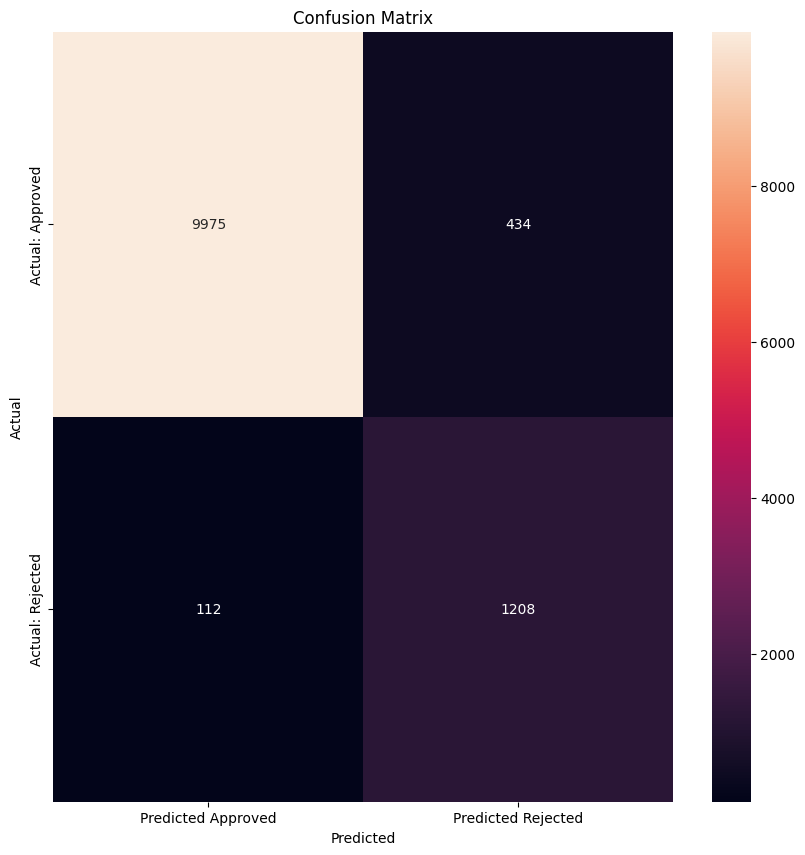

In [49]:
confusion_matrix_plot(9975, 112, 434, 1208)

#### Treino com balance_classes:

In [28]:
xgboost_model('data/train.csv', 'data/test.csv', classWeightbool=True, use_feature_eng=False)

Exatidão (validação): 0.9263364310682922

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96     10087
           1       0.70      0.83      0.76      1642

    accuracy                           0.93     11729
   macro avg       0.84      0.89      0.86     11729
weighted avg       0.93      0.93      0.93     11729

Matriz de confusão:
[[9505  582]
 [ 282 1360]]
Tempo de treino: 0.8269 segundos
Tempo de predição (validação): 0.0123 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.1022 segundos
[XGBoost] Tempo de execução: 1.25 segundos


##### Resultados:

**Exatidão (validação):** 0.9252280671839032

**Classification report:**

| Classification   | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0                | 0.97      | 0.94   | 0.96     | 10087   |
| 1                | 0.70      | 0.83   | 0.76     | 1642    |
| **Accuracy**     |           |        | 0.93     | 11729   |
| **Macro Avg**    | 0.83      | 0.89   | 0.86     | 11729   |
| **Weighted Avg** | 0.93      | 0.93   | 0.93     | 11729   |

**Matriz de confusão:**
[[9489  598]
 [ 279 1363]]

**Tempo de treino:** 0.3060 segundos

**Tempo de predição (validação):** 0.0070 segundos

**Tempo para processar teste:** 0.1350 segundos
**Tempo de execução:** 0.73 segundos

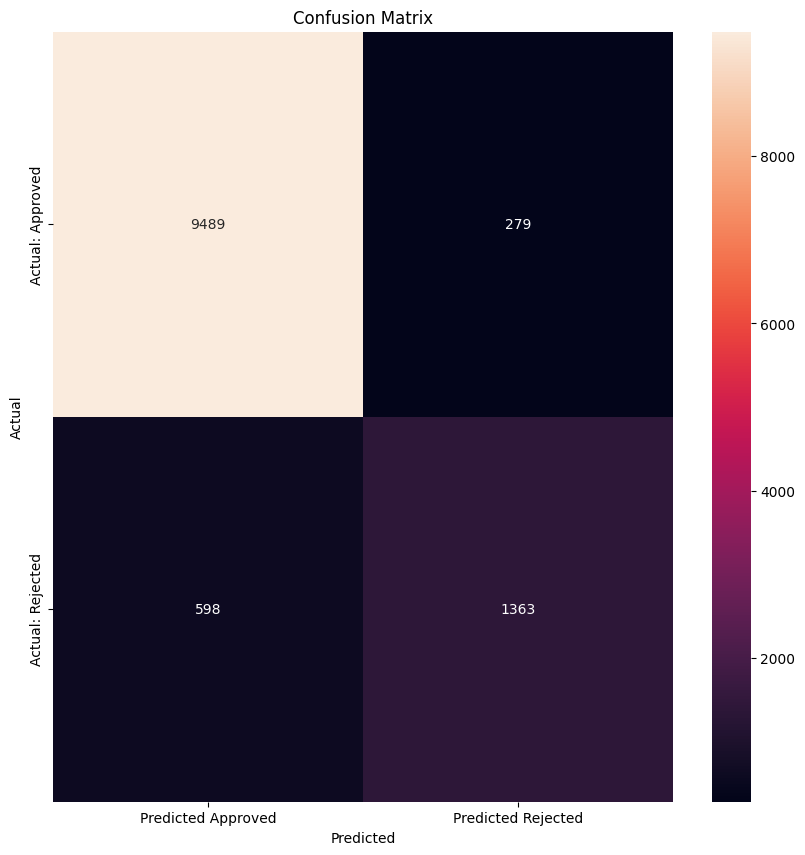

In [50]:
confusion_matrix_plot(9489, 598, 279, 1363)

##### Conclusão:

- Melhorou o recall porem pirou outras metricas talvez mais importantes como a precisao e o f1-score, levando um aumento do numero de falsos negativos
- Isto aconteceu pois o modelo dá mais importância à classe minoritária (no teu caso, o loan_status = 1). 

#### Uso de Feature engineering

In [29]:
xgboost_model('data/train.csv', 'data/test.csv', classWeightbool=False, use_feature_eng=False)

Exatidão (validação): 0.9533634580953193

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.91      0.74      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729

Matriz de confusão:
[[9974  113]
 [ 434 1208]]
Tempo de treino: 0.7922 segundos
Tempo de predição (validação): 0.0077 segundos
Submission saved on 'submission.csv'
Tempo para processar teste: 0.0991 segundos
[XGBoost] Tempo de execução: 1.15 segundos


##### Resultados:

**Exatidão (validação):** 0.9499531076818143

**Classification report:**

| Classification   | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| 0                | 0.96      | 0.99   | 0.97     | 10087   |
| 1                | 0.90      | 0.72   | 0.80     | 1642    |
| **Accuracy**     |           |        | 0.95     | 11729   |
| **Macro Avg**    | 0.93      | 0.86   | 0.89     | 11729   |
| **Weighted Avg** | 0.95      | 0.95   | 0.95     | 11729   |

**Matriz de confusão:**
[[9953  134]
 [ 453 1189]]

**Tempo de treino:** 0.3670 segundos

**Tempo de predição (validação):** 0.0080 segundos

**Tempo para processar teste:** 0.1570 segundos

**Tempo de execução:** 0.83 segundos

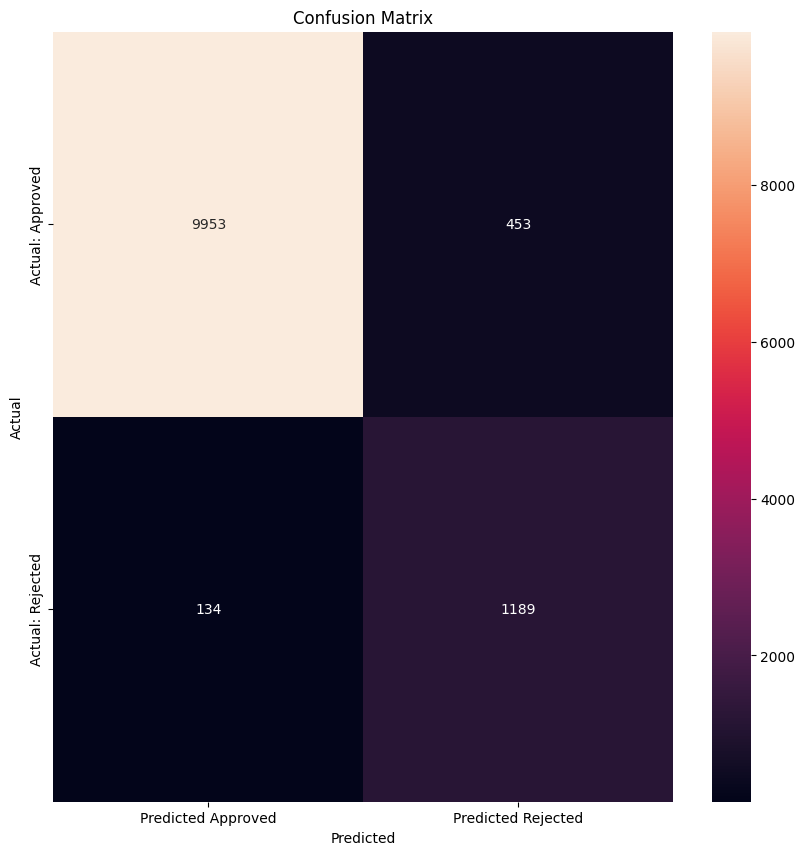

In [51]:
confusion_matrix_plot(9953, 134, 453, 1189)

##### Interpretação

- O modelo base é forte para a classe maioritária, mas perde alguns positivos.

- Equilibrio melhora o recall da classe minoritária, mas prejudica precisão e f1-score, aumentando falsos positivos.

- Feature engineering ajudou pouco, mantendo resultados similares.

- Dependendo do objetivo, pode-se escolher entre maior precisão (modelo base) ou maior recall (Equilibrio).